## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0716 07:46:53.079630 10408 deprecation_wrapper.py:119] From C:\Users\jerry\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0716 07:46:53.080627 10408 deprecation_wrapper.py:119] From C:\Users\jerry\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0716 07:46:53.100606 10408 deprecation_wrapper.py:119] From C:\Users\jerry\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 07:46:53.101620 10408 deprecation_wrapper.py:119] From C:\Users\jerry\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 07:46:53.106565 10408 

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0716 07:46:53.312008 10408 deprecation.py:323] From C:\Users\jerry\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 154us/step - loss: 15.0826 - acc: 0.2728 - val_loss: 13.9514 - val_acc: 0.3372
Epoch 2/50
50000/50000 [==============================] - 8s 155us/step - loss: 13.0171 - acc: 0.3576 - val_loss: 12.1205 - val_acc: 0.3751
Epoch 3/50
50000/50000 [==============================] - 8s 158us/step - loss: 11.3408 - acc: 0.3844 - val_loss: 10.6056 - val_acc: 0.3805
Epoch 4/50
50000/50000 [==============================] - 8s 154us/step - loss: 9.9288 - acc: 0.3959 - val_loss: 9.2926 - val_acc: 0.4019
Epoch 5/50
50000/50000 [==============================] - 7s 139us/step - loss: 8.7290 - acc: 0.4080 - val_loss: 8.1853 - val_acc: 0.4145
Epoch 6/50
50000/50000 [==============================] - 7s 145us/step - loss: 7.7070 - acc: 0.4163 - val_loss: 7.2420 - val_acc: 0.4204
Epoch 7/50
50000/50000 [==============================] - 7s 135us/step - loss: 6.8368 - acc: 0.4224 - val_loss: 6.4

Epoch 2/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.9581 - acc: 0.3602 - val_loss: 1.9105 - val_acc: 0.3735
Epoch 3/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.8730 - acc: 0.3924 - val_loss: 1.8397 - val_acc: 0.4049
Epoch 4/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.8133 - acc: 0.4142 - val_loss: 1.7906 - val_acc: 0.4237
Epoch 5/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.7654 - acc: 0.4302 - val_loss: 1.7445 - val_acc: 0.4363
Epoch 6/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.7256 - acc: 0.4442 - val_loss: 1.7278 - val_acc: 0.4366
Epoch 7/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.6921 - acc: 0.4548 - val_loss: 1.6950 - val_acc: 0.4490
Epoch 8/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.6621 - acc: 0.4647 - val_loss: 1.6658 - val_acc: 0.4591
Epoch 9/50
50000/50000 [==========

50000/50000 [==============================] - 7s 139us/step - loss: 1.7249 - acc: 0.3959 - val_loss: 1.7024 - val_acc: 0.4015
Epoch 4/50
50000/50000 [==============================] - 7s 140us/step - loss: 1.6660 - acc: 0.4173 - val_loss: 1.6522 - val_acc: 0.4182
Epoch 5/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.6201 - acc: 0.4330 - val_loss: 1.6075 - val_acc: 0.4350
Epoch 6/50
50000/50000 [==============================] - 7s 140us/step - loss: 1.5797 - acc: 0.4468 - val_loss: 1.5856 - val_acc: 0.4393
Epoch 7/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.5471 - acc: 0.4579 - val_loss: 1.5518 - val_acc: 0.4549
Epoch 8/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.5153 - acc: 0.4689 - val_loss: 1.5449 - val_acc: 0.4563
Epoch 9/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.4872 - acc: 0.4778 - val_loss: 1.5164 - val_acc: 0.4619
Epoch 10/50
50000/50000 [====================

50000/50000 [==============================] - 7s 141us/step - loss: 1.6616 - acc: 0.4191 - val_loss: 1.6456 - val_acc: 0.4260
Epoch 5/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.6151 - acc: 0.4350 - val_loss: 1.5989 - val_acc: 0.4408
Epoch 6/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.5750 - acc: 0.4469 - val_loss: 1.5674 - val_acc: 0.4460
Epoch 7/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.5416 - acc: 0.4596 - val_loss: 1.5491 - val_acc: 0.4581
Epoch 8/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.5114 - acc: 0.4708 - val_loss: 1.5234 - val_acc: 0.4618
Epoch 9/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.4841 - acc: 0.4808 - val_loss: 1.5059 - val_acc: 0.4675
Epoch 10/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.4594 - acc: 0.4875 - val_loss: 1.4942 - val_acc: 0.4684
Epoch 11/50
50000/50000 [===================

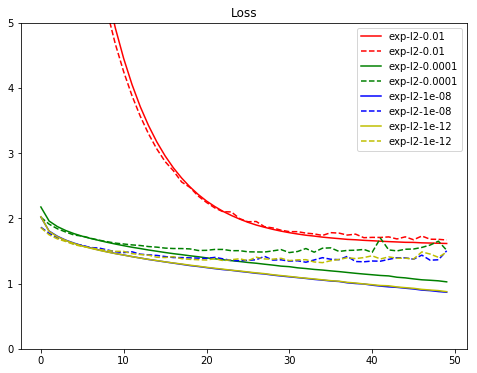

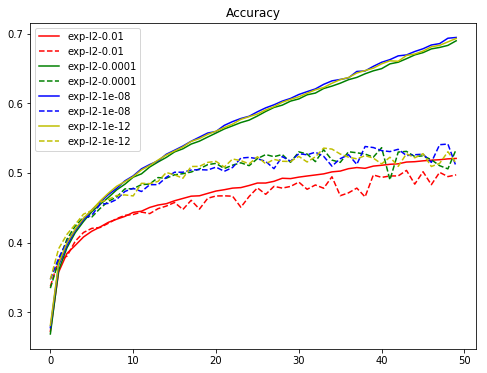

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [20]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12] 

In [21]:
results = {}
"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [22]:
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 141us/step - loss: 6.0084 - acc: 0.2756 - val_loss: 5.8100 - val_acc: 0.3410
Epoch 2/50
50000/50000 [==============================] - 7s 135us/step - loss: 5.7269 - acc: 0.3616 - val_loss: 5.6459 - val_acc: 0.3820
Epoch 3/50
50000/50000 [==============================] - 7s 132us/step - loss: 5.5868 - acc: 0.3902 - val_loss: 5.5229 - val_acc: 0.3972
Epoch 4/50
50000/50000 [==============================] - 7s 132us/step - loss: 5.4671 - acc: 0.4102 - val_loss: 5.4051 - val_acc: 0.4199
Epoch 5/50
50000/50000 [==============================] - 7s 133us/step - loss: 5.3581 - acc: 0.4251 - val_loss: 5.3114 - val_acc: 0.4314
Epoch 6/50
50000/50000 [==============================] - 7s 133us/step - loss: 5.2556 - acc: 0.4398 - val_loss: 5.2116 - val_acc: 0.4435
Epoch 7/50
50000/50000 [==============================] - 7s 134us/step - loss: 5.1614 - acc: 0.4525 - val_loss: 5.1255 - 

Epoch 2/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.8013 - acc: 0.3678 - val_loss: 1.7586 - val_acc: 0.3841
Epoch 3/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.7227 - acc: 0.3955 - val_loss: 1.6911 - val_acc: 0.4016
Epoch 4/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.6674 - acc: 0.4158 - val_loss: 1.6459 - val_acc: 0.4190
Epoch 5/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.6194 - acc: 0.4331 - val_loss: 1.6020 - val_acc: 0.4393
Epoch 6/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.5782 - acc: 0.4457 - val_loss: 1.5754 - val_acc: 0.4417
Epoch 7/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.5452 - acc: 0.4563 - val_loss: 1.5433 - val_acc: 0.4544
Epoch 8/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.5142 - acc: 0.4680 - val_loss: 1.5231 - val_acc: 0.4641
Epoch 9/50
50000/50000 [==========

50000/50000 [==============================] - 6s 128us/step - loss: 1.7229 - acc: 0.3958 - val_loss: 1.6879 - val_acc: 0.4057
Epoch 4/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.6637 - acc: 0.4172 - val_loss: 1.6387 - val_acc: 0.4319
Epoch 5/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.6144 - acc: 0.4359 - val_loss: 1.5993 - val_acc: 0.4373
Epoch 6/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.5741 - acc: 0.4490 - val_loss: 1.5781 - val_acc: 0.4430
Epoch 7/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.5425 - acc: 0.4590 - val_loss: 1.5407 - val_acc: 0.4534
Epoch 8/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.5138 - acc: 0.4675 - val_loss: 1.5298 - val_acc: 0.4585
Epoch 9/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.4886 - acc: 0.4777 - val_loss: 1.4983 - val_acc: 0.4703
Epoch 10/50
50000/50000 [====================

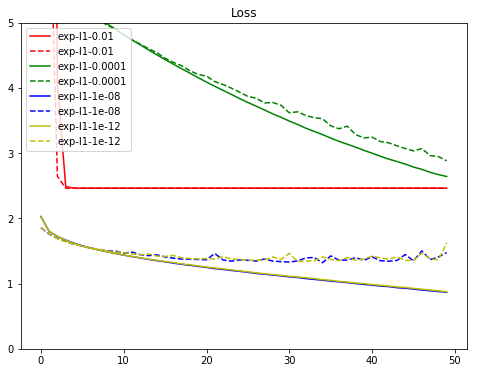

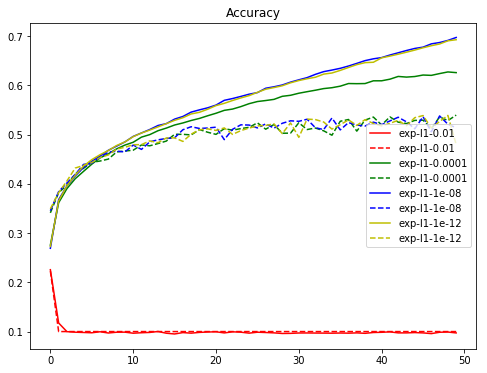

In [23]:
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [24]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12] 

In [25]:
results = {}
"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [36]:
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    for regulizer_ratio2 in L2_EXP:
        
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer L1= %.6f, L2= %.6f " % (regulizer_ratio, regulizer_ratio2))
        model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio, l2_ratio=regulizer_ratio2)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-l1l2-[%s-%s]" % (str(regulizer_ratio), str(regulizer_ratio2))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with Regulizer L1= 0.010000, L2= 0.010000 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 165us/step - loss: 198.6402 - acc: 0.2529 - val_loss: 41.0920 - val_acc: 0.2645
Epoch 2/50
50000/50000 [==============================] - 8s 154us/step - loss: 19.0926 - acc: 0.1180 - val_loss: 7.2636 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 8s 154us/step - loss: 4.0945 - acc: 0.0991 - val_loss: 2.6430 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.4855 - acc: 0.0998 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.4626 - acc: 0.0982 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.4626 - acc: 0.0977 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.4626 - acc: 0.0988 - val_loss: 2.462

50000/50000 [==============================] - 8s 167us/step - loss: 198.7620 - acc: 0.2387 - val_loss: 41.2147 - val_acc: 0.2777
Epoch 2/50
50000/50000 [==============================] - 8s 157us/step - loss: 19.1683 - acc: 0.1220 - val_loss: 7.3029 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 8s 158us/step - loss: 4.1178 - acc: 0.0991 - val_loss: 2.6488 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 8s 156us/step - loss: 2.4860 - acc: 0.0979 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 8s 159us/step - loss: 2.4626 - acc: 0.0975 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 8s 157us/step - loss: 2.4626 - acc: 0.0981 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 8s 157us/step - loss: 2.4626 - acc: 0.0971 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 8/50
50000/50000 [=================

50000/50000 [==============================] - 8s 156us/step - loss: 19.1290 - acc: 0.1213 - val_loss: 7.2803 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 8s 156us/step - loss: 4.1029 - acc: 0.0998 - val_loss: 2.6493 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 8s 155us/step - loss: 2.4870 - acc: 0.0990 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 9s 188us/step - loss: 2.4626 - acc: 0.0982 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.4626 - acc: 0.0976 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 9s 174us/step - loss: 2.4626 - acc: 0.0947 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.4626 - acc: 0.0983 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 9/50
50000/50000 [====================

50000/50000 [==============================] - 8s 155us/step - loss: 13.9647 - acc: 0.3793 - val_loss: 12.9854 - val_acc: 0.3785
Epoch 4/50
50000/50000 [==============================] - 8s 155us/step - loss: 12.1147 - acc: 0.3908 - val_loss: 11.2799 - val_acc: 0.3986
Epoch 5/50
50000/50000 [==============================] - 8s 153us/step - loss: 10.5424 - acc: 0.4013 - val_loss: 9.8360 - val_acc: 0.4012
Epoch 6/50
50000/50000 [==============================] - 8s 154us/step - loss: 9.2044 - acc: 0.4078 - val_loss: 8.6011 - val_acc: 0.4091
Epoch 7/50
50000/50000 [==============================] - 8s 153us/step - loss: 8.0644 - acc: 0.4128 - val_loss: 7.5568 - val_acc: 0.4138
Epoch 8/50
50000/50000 [==============================] - 8s 154us/step - loss: 7.0935 - acc: 0.4187 - val_loss: 6.6573 - val_acc: 0.4225
Epoch 9/50
50000/50000 [==============================] - 8s 154us/step - loss: 6.2658 - acc: 0.4230 - val_loss: 5.8920 - val_acc: 0.4226
Epoch 10/50
50000/50000 [===============

50000/50000 [==============================] - 8s 155us/step - loss: 5.5798 - acc: 0.4104 - val_loss: 5.5359 - val_acc: 0.4120
Epoch 5/50
50000/50000 [==============================] - 8s 154us/step - loss: 5.4645 - acc: 0.4268 - val_loss: 5.4131 - val_acc: 0.4284
Epoch 6/50
50000/50000 [==============================] - 8s 155us/step - loss: 5.3582 - acc: 0.4396 - val_loss: 5.3191 - val_acc: 0.4418
Epoch 7/50
50000/50000 [==============================] - 8s 156us/step - loss: 5.2582 - acc: 0.4523 - val_loss: 5.2199 - val_acc: 0.4548
Epoch 8/50
50000/50000 [==============================] - 8s 155us/step - loss: 5.1626 - acc: 0.4634 - val_loss: 5.1300 - val_acc: 0.4571
Epoch 9/50
50000/50000 [==============================] - 8s 157us/step - loss: 5.0710 - acc: 0.4706 - val_loss: 5.0571 - val_acc: 0.4593
Epoch 10/50
50000/50000 [==============================] - 8s 154us/step - loss: 4.9811 - acc: 0.4789 - val_loss: 4.9624 - val_acc: 0.4714
Epoch 11/50
50000/50000 [===================

50000/50000 [==============================] - 8s 153us/step - loss: 5.3388 - acc: 0.4327 - val_loss: 5.2954 - val_acc: 0.4350
Epoch 6/50
50000/50000 [==============================] - 8s 152us/step - loss: 5.2400 - acc: 0.4455 - val_loss: 5.2131 - val_acc: 0.4451
Epoch 7/50
50000/50000 [==============================] - 8s 151us/step - loss: 5.1449 - acc: 0.4574 - val_loss: 5.1229 - val_acc: 0.4563
Epoch 8/50
50000/50000 [==============================] - 8s 155us/step - loss: 5.0568 - acc: 0.4668 - val_loss: 5.0416 - val_acc: 0.4596
Epoch 9/50
50000/50000 [==============================] - 8s 154us/step - loss: 4.9702 - acc: 0.4747 - val_loss: 4.9628 - val_acc: 0.4621
Epoch 10/50
50000/50000 [==============================] - 8s 154us/step - loss: 4.8868 - acc: 0.4849 - val_loss: 4.8749 - val_acc: 0.4746
Epoch 11/50
50000/50000 [==============================] - 8s 154us/step - loss: 4.8060 - acc: 0.4911 - val_loss: 4.8380 - val_acc: 0.4638
Epoch 12/50
50000/50000 [==================

50000/50000 [==============================] - 8s 154us/step - loss: 5.2438 - acc: 0.4441 - val_loss: 5.2074 - val_acc: 0.4458
Epoch 7/50
50000/50000 [==============================] - 8s 154us/step - loss: 5.1491 - acc: 0.4561 - val_loss: 5.1173 - val_acc: 0.4597
Epoch 8/50
50000/50000 [==============================] - 8s 152us/step - loss: 5.0609 - acc: 0.4628 - val_loss: 5.0439 - val_acc: 0.4572
Epoch 9/50
50000/50000 [==============================] - 8s 153us/step - loss: 4.9739 - acc: 0.4737 - val_loss: 4.9532 - val_acc: 0.4665
Epoch 10/50
50000/50000 [==============================] - 8s 151us/step - loss: 4.8902 - acc: 0.4827 - val_loss: 4.8956 - val_acc: 0.4671
Epoch 11/50
50000/50000 [==============================] - 8s 151us/step - loss: 4.8091 - acc: 0.4879 - val_loss: 4.8157 - val_acc: 0.4697
Epoch 12/50
50000/50000 [==============================] - 8s 151us/step - loss: 4.7269 - acc: 0.4968 - val_loss: 4.7312 - val_acc: 0.4805
Epoch 13/50
50000/50000 [=================

50000/50000 [==============================] - 8s 154us/step - loss: 6.8303 - acc: 0.4267 - val_loss: 6.4393 - val_acc: 0.4320
Epoch 8/50
50000/50000 [==============================] - 8s 154us/step - loss: 6.0867 - acc: 0.4329 - val_loss: 5.7596 - val_acc: 0.4315
Epoch 9/50
50000/50000 [==============================] - 8s 154us/step - loss: 5.4498 - acc: 0.4388 - val_loss: 5.1691 - val_acc: 0.4334
Epoch 10/50
50000/50000 [==============================] - 8s 154us/step - loss: 4.9069 - acc: 0.4437 - val_loss: 4.6715 - val_acc: 0.4372
Epoch 11/50
50000/50000 [==============================] - 8s 153us/step - loss: 4.4420 - acc: 0.4479 - val_loss: 4.2304 - val_acc: 0.4534
Epoch 12/50
50000/50000 [==============================] - 8s 151us/step - loss: 4.0440 - acc: 0.4506 - val_loss: 3.8680 - val_acc: 0.4537
Epoch 13/50
50000/50000 [==============================] - 8s 151us/step - loss: 3.7022 - acc: 0.4555 - val_loss: 3.5590 - val_acc: 0.4524
Epoch 14/50
50000/50000 [================

50000/50000 [==============================] - 8s 151us/step - loss: 1.6672 - acc: 0.4643 - val_loss: 1.6741 - val_acc: 0.4545
Epoch 9/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.6391 - acc: 0.4727 - val_loss: 1.6624 - val_acc: 0.4558
Epoch 10/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.6135 - acc: 0.4828 - val_loss: 1.6519 - val_acc: 0.4676
Epoch 11/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.5899 - acc: 0.4904 - val_loss: 1.6171 - val_acc: 0.4805
Epoch 12/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.5659 - acc: 0.4994 - val_loss: 1.6258 - val_acc: 0.4677
Epoch 13/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.5441 - acc: 0.5075 - val_loss: 1.5851 - val_acc: 0.4856
Epoch 14/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.5236 - acc: 0.5146 - val_loss: 1.5819 - val_acc: 0.4870
Epoch 15/50
50000/50000 [===============

50000/50000 [==============================] - 9s 185us/step - loss: 1.4864 - acc: 0.4792 - val_loss: 1.5333 - val_acc: 0.4616
Epoch 10/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.4630 - acc: 0.4860 - val_loss: 1.5016 - val_acc: 0.4673
Epoch 11/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.4387 - acc: 0.4937 - val_loss: 1.4739 - val_acc: 0.4806
Epoch 12/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.4179 - acc: 0.5009 - val_loss: 1.4624 - val_acc: 0.4775
Epoch 13/50
50000/50000 [==============================] - 10s 207us/step - loss: 1.3974 - acc: 0.5093 - val_loss: 1.4494 - val_acc: 0.4833
Epoch 14/50
50000/50000 [==============================] - 11s 210us/step - loss: 1.3771 - acc: 0.5162 - val_loss: 1.4469 - val_acc: 0.4839
Epoch 15/50
50000/50000 [==============================] - 10s 204us/step - loss: 1.3580 - acc: 0.5235 - val_loss: 1.4287 - val_acc: 0.4936
Epoch 16/50
50000/50000 [==========

Epoch 10/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.4575 - acc: 0.4885 - val_loss: 1.4820 - val_acc: 0.4733
Epoch 11/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.4334 - acc: 0.4944 - val_loss: 1.4825 - val_acc: 0.4761
Epoch 12/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.4112 - acc: 0.5055 - val_loss: 1.4841 - val_acc: 0.4678
Epoch 13/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.3894 - acc: 0.5119 - val_loss: 1.4443 - val_acc: 0.4831
Epoch 14/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.3702 - acc: 0.5178 - val_loss: 1.4311 - val_acc: 0.4902
Epoch 15/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.3497 - acc: 0.5233 - val_loss: 1.4324 - val_acc: 0.4948
Epoch 16/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.3312 - acc: 0.5318 - val_loss: 1.4202 - val_acc: 0.4906
Epoch 17/50
50000/50000 [==

Epoch 11/50
50000/50000 [==============================] - 8s 163us/step - loss: 4.4546 - acc: 0.4404 - val_loss: 4.2464 - val_acc: 0.4439
Epoch 12/50
50000/50000 [==============================] - 8s 164us/step - loss: 4.0551 - acc: 0.4457 - val_loss: 3.8782 - val_acc: 0.4437
Epoch 13/50
50000/50000 [==============================] - 8s 165us/step - loss: 3.7146 - acc: 0.4495 - val_loss: 3.5642 - val_acc: 0.4474
Epoch 14/50
50000/50000 [==============================] - 8s 164us/step - loss: 3.4240 - acc: 0.4514 - val_loss: 3.2978 - val_acc: 0.4506
Epoch 15/50
50000/50000 [==============================] - 8s 163us/step - loss: 3.1735 - acc: 0.4547 - val_loss: 3.0729 - val_acc: 0.4508
Epoch 16/50
50000/50000 [==============================] - 8s 163us/step - loss: 2.9588 - acc: 0.4600 - val_loss: 2.8948 - val_acc: 0.4379
Epoch 17/50
50000/50000 [==============================] - 8s 162us/step - loss: 2.7752 - acc: 0.4621 - val_loss: 2.7192 - val_acc: 0.4485
Epoch 18/50
50000/50000 [==

50000/50000 [==============================] - 8s 163us/step - loss: 1.5421 - acc: 0.5076 - val_loss: 1.6040 - val_acc: 0.4783
Epoch 13/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.5184 - acc: 0.5144 - val_loss: 1.5720 - val_acc: 0.4953
Epoch 14/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.4983 - acc: 0.5247 - val_loss: 1.5677 - val_acc: 0.4914
Epoch 15/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.4805 - acc: 0.5296 - val_loss: 1.5420 - val_acc: 0.5005
Epoch 16/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.4592 - acc: 0.5369 - val_loss: 1.5484 - val_acc: 0.4991
Epoch 17/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.4457 - acc: 0.5424 - val_loss: 1.5502 - val_acc: 0.4940
Epoch 18/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.4281 - acc: 0.5472 - val_loss: 1.5275 - val_acc: 0.5104
Epoch 19/50
50000/50000 [==============

50000/50000 [==============================] - 8s 158us/step - loss: 1.3924 - acc: 0.5105 - val_loss: 1.4420 - val_acc: 0.4882
Epoch 14/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.3722 - acc: 0.5175 - val_loss: 1.4192 - val_acc: 0.4996
Epoch 15/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.3526 - acc: 0.5244 - val_loss: 1.4533 - val_acc: 0.4861
Epoch 16/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.3359 - acc: 0.5296 - val_loss: 1.4123 - val_acc: 0.5013
Epoch 17/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.3187 - acc: 0.5361 - val_loss: 1.4008 - val_acc: 0.5009
Epoch 18/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.2995 - acc: 0.5427 - val_loss: 1.3959 - val_acc: 0.5023
Epoch 19/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.2861 - acc: 0.5482 - val_loss: 1.4313 - val_acc: 0.4959
Epoch 20/50
50000/50000 [==============

50000/50000 [==============================] - 8s 158us/step - loss: 1.3701 - acc: 0.5192 - val_loss: 1.4158 - val_acc: 0.5010
Epoch 15/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.3504 - acc: 0.5251 - val_loss: 1.4108 - val_acc: 0.4978
Epoch 16/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.3313 - acc: 0.5309 - val_loss: 1.4361 - val_acc: 0.4895
Epoch 17/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.3132 - acc: 0.5378 - val_loss: 1.4015 - val_acc: 0.4991
Epoch 18/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.2966 - acc: 0.5438 - val_loss: 1.4282 - val_acc: 0.4978
Epoch 19/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.2812 - acc: 0.5500 - val_loss: 1.3970 - val_acc: 0.5059
Epoch 20/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.2645 - acc: 0.5551 - val_loss: 1.4498 - val_acc: 0.4895
Epoch 21/50
50000/50000 [==============

In [38]:
results.keys()

dict_keys(['exp-l1l2-[0.01-0.01]', 'exp-l1l2-[0.01-0.0001]', 'exp-l1l2-[0.01-1e-08]', 'exp-l1l2-[0.01-1e-12]', 'exp-l1l2-[0.0001-0.01]', 'exp-l1l2-[0.0001-0.0001]', 'exp-l1l2-[0.0001-1e-08]', 'exp-l1l2-[0.0001-1e-12]', 'exp-l1l2-[1e-08-0.01]', 'exp-l1l2-[1e-08-0.0001]', 'exp-l1l2-[1e-08-1e-08]', 'exp-l1l2-[1e-08-1e-12]', 'exp-l1l2-[1e-12-0.01]', 'exp-l1l2-[1e-12-0.0001]', 'exp-l1l2-[1e-12-1e-08]', 'exp-l1l2-[1e-12-1e-12]'])

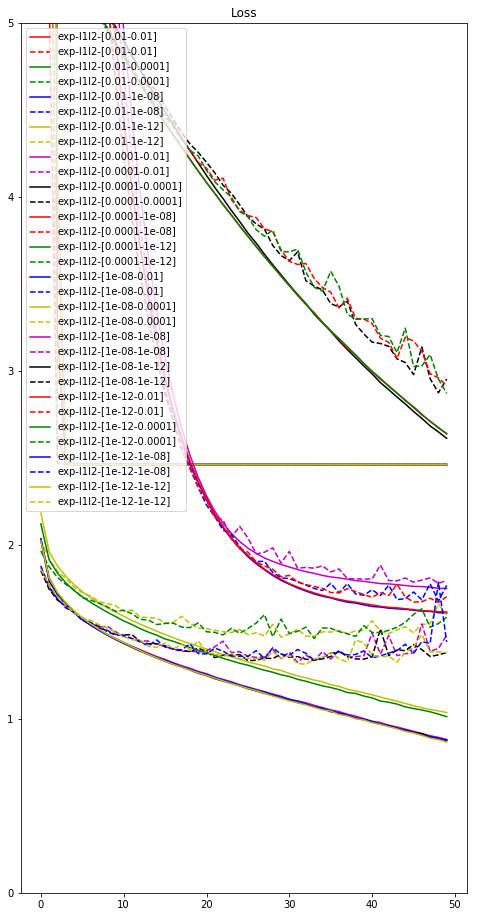

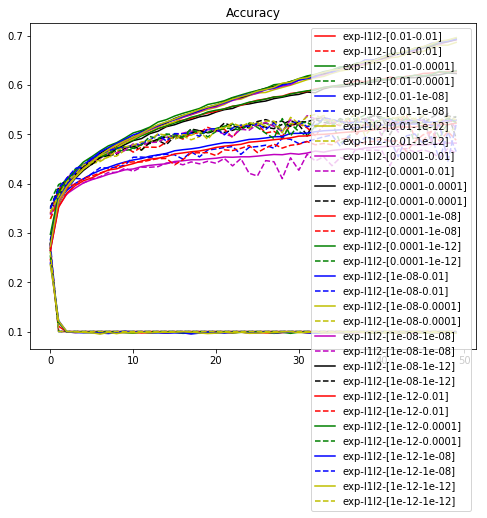

In [41]:
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k","r", "g", "b", "y", "m", "k","r", "g", "b", "y"]

plt.figure(figsize=(8,16))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()